### 1. Exploração dos Dados e Pré-processamento

##### importando as bibliotecas

In [2]:
# Importando libraries para EDA e manipulação de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Libraries para os modelos e tunagem de parâmetros no estudo
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carregar a série temporal
data = pd.read_csv('Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas.csv', encoding='ISO-8859-1', sep=';', parse_dates=['Data'], index_col='Data')
# Converte a coluna removendo pontos e trocando a vírgula por ponto
data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'] = (
    data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)']
    .str.replace('.', '', regex=False)  # Remove os pontos
    .str.replace(',', '.', regex=False)  # Troca a vírgula por ponto
    .astype(float)                       # Converte para float
)

### 1. Verificação de Estacionariedade: 

A série deve ser estacionária para aplicar o modelo GARCH. Para verificar a estacionariedade, use o teste de Dickey-Fuller Aumentado (ADF).

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 4.396895094061529
p-value: 1.0


Se a série não for estacionária, será necessário diferenciar a série até que ela se torne estacionária.

Transformação de Dados: Caso a série apresente heterocedasticidade, pode-se aplicar logaritmo ou diferenciação logarítmica.

In [5]:
data['Log_Saldo'] = np.log(data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'])


### 2. Análise de Volatilidade

Análise Gráfica: Verifique visualmente se há sinais de volatilidade ao longo do tempo.

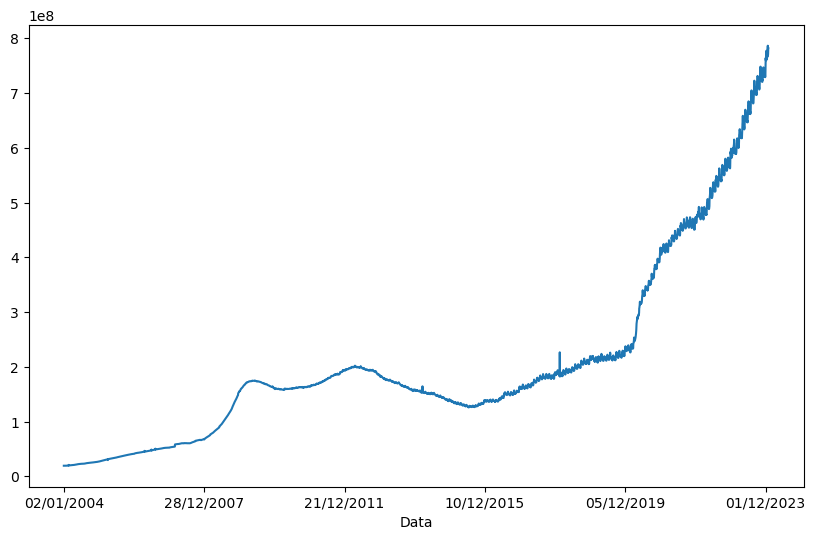

In [7]:
data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'].plot(figsize=(10,6))
plt.show()


Autocorrelação dos Resíduos Quadrados: Verifique se os resíduos ao quadrado da série temporal mostram autocorrelação, um indicativo da presença de heterocedasticidade.

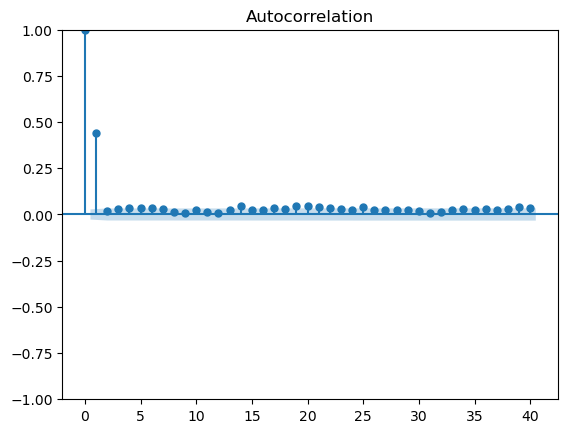

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
residuals = data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'].diff().dropna()
plot_acf(residuals**2, lags=40)
plt.show()


### 3. Seleção do Modelo

##### Auto GARCH

In [23]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

# Carregar a série temporal
data = pd.read_csv(
    'Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas.csv',
    encoding='ISO-8859-1',
    sep=';',
    parse_dates=['Data'],
    index_col='Data'
)

# Converte a coluna removendo pontos e trocando a vírgula por ponto
data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'] = (
    data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)']
    .str.replace('.', '', regex=False)  # Remove os pontos
    .str.replace(',', '.', regex=False)  # Troca a vírgula por ponto
    .astype(float)                       # Converte para float
)



# Diferenciar a série
data['Diff_Saldo'] = np.log(data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'])


# Função para selecionar o melhor modelo GARCH
def auto_garch(data, p_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Loop para testar diferentes ordens p e q
    for p in p_range:
        for q in q_range:
            try:
                model = arch_model(data, vol='Garch', p=p, q=q)
                model_fitted = model.fit(disp='off')
                aic = model_fitted.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
                    best_model = model_fitted
            except Exception as e:
                print(f"Erro com p={p}, q={q}: {e}")

    return best_model, best_order

# Definir intervalos para p e q
p_range = range(1, 5)
q_range = range(1, 5)

# Aplicar o AutoGARCH na série diferenciada
best_model, best_order = auto_garch(data['Diff_Saldo'].dropna(), p_range, q_range)

# Exibir o melhor modelo encontrado
if best_model:
    print(f"Melhor ordem (p, q): {best_order}")
    print(best_model.summary())
else:
    print("Nenhum modelo GARCH foi encontrado.")


c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Melhor ordem (p, q): (1, 4)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Diff_Saldo   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -191.174
Distribution:                  Normal   AIC:                           396.349
Method:            Maximum Likelihood   BIC:                           441.997
                                        No. Observations:                 5020
Date:                Thu, Oct 10 2024   Df Residuals:                     5019
Time:                        12:00:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            18.9099  3.125e-04  6.052e+0

##### Especificação do Modelo: O próximo passo é identificar a ordem dos modelos ARCH ou GARCH que serão usados. 

GARCH(1,4)

In [24]:
from arch import arch_model
model = arch_model(data['1168 - Saldo em juros flutuantes DI de depositos a prazo (CDBRDB) - Pessoas fisicas - u.m.c. (mil)'], vol='Garch', p=1, q=4)


### 4. Estimação do Modelo

Ajuste do Modelo: Após escolher o modelo, ajuste-o à série de dados.

In [25]:
model_fitted = model.fit()
print(model_fitted.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 215281.21997122263
Iteration:      2,   Func. Count:     18,   Neg. LLF: 98074.78623523304
Iteration:      3,   Func. Count:     26,   Neg. LLF: 98061.4634826954
Iteration:      4,   Func. Count:     34,   Neg. LLF: 98057.39356011932
Iteration:      5,   Func. Count:     42,   Neg. LLF: 98056.89528689567
Iteration:      6,   Func. Count:     50,   Neg. LLF: 98056.88569766529
Iteration:      7,   Func. Count:     58,   Neg. LLF: 98056.88568013399
Iteration:      8,   Func. Count:     65,   Neg. LLF: 98056.88568503212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 98056.88568013399
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
                                                             Constant Mean - GARCH Model Results                                                              
Dep. Variable:     1168 - Saldo em juros flutuantes DI de 

### 5. Diagnóstico do Modelo

Verificação dos Resíduos: Verifique se os resíduos do modelo ajustado seguem uma distribuição normal e se o modelo capturou a heterocedasticidade adequadamente.

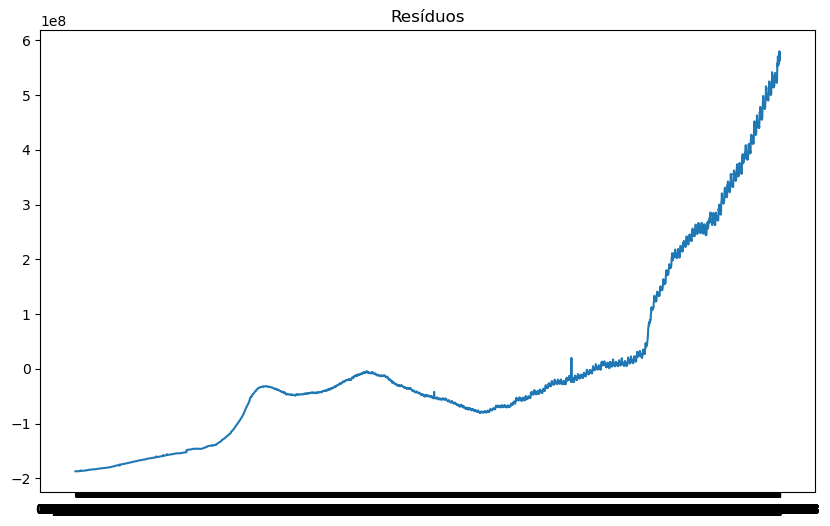

In [26]:
residuals = model_fitted.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Resíduos')
plt.show()

Teste de Engle's ARCH: Para confirmar a ausência de heterocedasticidade nos resíduos ajustados.

In [27]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(model_fitted.resid)
print('p-value:', arch_test[1])


p-value: 0.0


### 6. Previsão

Previsão de Volatilidade: Depois que o modelo estiver ajustado, você pode usar o modelo para prever a volatilidade futura.

In [28]:
forecast = model_fitted.forecast(horizon=10)
print(forecast.variance[-1:])


                    h.01          h.02          h.03          h.04  \
Data                                                                 
29/12/2023  2.868477e+17  2.488319e+17  2.159265e+17  1.874445e+17   

                    h.05          h.06          h.07          h.08  \
Data                                                                 
29/12/2023  1.627914e+17  1.414524e+17  1.229819e+17  1.069944e+17   

                    h.09          h.10  
Data                                    
29/12/2023  9.315612e+16  8.117808e+16  
